<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/facialKeyPointsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd  P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints'
all_img_paths = glob.glob(os.path.join(root_dir,'*.jpg'))

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 26.81 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [3]:
data =  pd.read_csv('/content/P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [4]:
data.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [9]:
class FacesData(Dataset):
  def __init__(self,df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std = [0.229, 0.224, 0.225]
    )
  def  __len__(self):
    return len(self.df)
  def __getitem__(self,ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
    img = cv2.imread(img_path)/255
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y  =   (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 =  kp_x+kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return  img,kp2
  def  preprocess_input(self,img):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)
  def load_img(self,ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
    img =  cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
    img = cv2.resize(img,(224,224))
    return img

In [10]:
from sklearn.model_selection import train_test_split
train,test  = train_test_split(data,test_size=0.2,random_state=10)
train_ds,test_ds = FacesData(train.reset_index(drop=True)),FacesData(test.reset_index(drop=True))

In [11]:
train_dl = DataLoader(train_ds,batch_size=32)
test_dl = DataLoader(test_ds,batch_size=32)


In [13]:
img,kp = next(iter(train_dl))

In [15]:
img.shape,kp.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 136]))

In [23]:
def get_model():
  model_w = models.VGG16_Weights.IMAGENET1K_V1
  model = models.vgg16(weights=model_w)
  for p in model.parameters():
    p.requires_grad = False
  print(model.avgpool)
  print(model.classifier)
  model.avgpool  =  nn.Sequential(
      nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )
  print(model.avgpool)
  model.classifier  = nn.Sequential(
      nn.Linear(2048,512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512,136),
      nn.Sigmoid()
  )
  print(model.classifier)
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), criterion, optimizer


In [24]:
model, criterion, optimizer = get_model()


AdaptiveAvgPool2d(output_size=(7, 7))
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Flatten(start_dim=1, end_dim=-1)
)
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=136, bias=True)
  (4): Sigmoid()
)


In [25]:
def  train_batch(img,kps,model,opt,criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  loss.backward()
  opt.step()
  return loss

In [26]:
def  validate_batch(img,kps,model,criterion):
  model.eval()
  _kps  =  model(img.to(device))
  loss =  criterion(_kps,kps.to(device))
  return  _kps,loss

In [27]:
train_loss, test_loss = [], []
n_epochs = 50
for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_dl):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)
    for ix,(img,kps) in enumerate(test_dl):
       ps,  loss = validate_batch(img, kps, model, criterion)
       epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


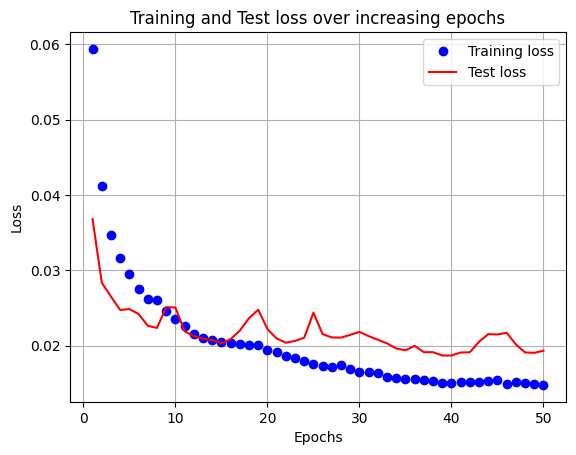

In [28]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

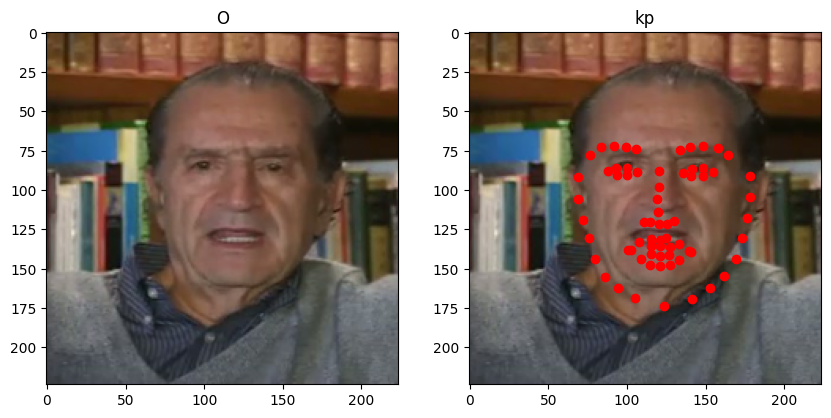

In [32]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('O')
im = test_ds.load_img(ix)
plt.imshow(im)
plt.grid(False)

plt.subplot(122)
plt.title('kp')
x,_ = test_ds[ix]
plt.imshow(im)
kp = model(x.unsqueeze(0)).flatten().detach().cpu()
plt.scatter(kp[:68]*224,kp[68:]*224,c='r')
plt.grid(False)
plt.show()

# 2D and 3D facial keypoint detection

In [33]:
!pip install -qU face-alignment
import  face_alignment,cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.4 MB/s eta 0:00:00


In [34]:
fa  = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.TWO_D,
    flip_input=False,device = 'cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:07<00:00, 12.5MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:05<00:00, 16.9MB/s]


In [42]:
input = cv2.imread('/content/images.jpeg')
preds =   fa.get_landmarks(input)[0]
preds.shape

(68, 2)

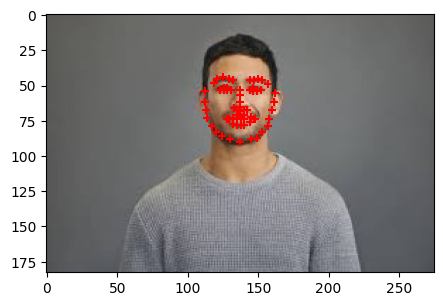

In [43]:
fig,ax = plt.subplots(figsize=(5,5))
plt.imshow(cv2.cvtColor(input, cv2.COLOR_BGR2RGB))
ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')
plt.show()

In [44]:
#3d
fa  = face_alignment.FaceAlignment(
    face_alignment.LandmarksType.THREE_D,
    flip_input=False,device = 'cpu')


Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip
100%|██████████| 91.9M/91.9M [00:07<00:00, 13.4MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip
100%|██████████| 224M/224M [00:18<00:00, 13.0MB/s]


In [45]:
preds =  fa.get_landmarks(input)[0]
df = pd.DataFrame(preds)

In [48]:
df.head()

,0,1,2
0,111.0,53.0,-17.546663
1,111.0,61.0,-17.291113
2,113.0,66.0,-17.115124
3,114.0,73.0,-16.203104
4,116.0,79.0,-13.263840


In [49]:
df.columns = ['x','y','z']

In [51]:
df.head()

,x,y,z
0,111.0,53.0,-17.546663
1,111.0,61.0,-17.291113
2,113.0,66.0,-17.115124
3,114.0,73.0,-16.203104
4,116.0,79.0,-13.263840


In [52]:
import  plotly.express  as px
fig = px.scatter_3d(df,x='x',y='y',z='z')
fig.show()